In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from theoretical_pulsed import TheoreticalPulsedSqueezing, TheoreticalPulsed1D, PulsedSqueezingVisualizer
import numpy as np

# Theory of Pulsed Squeezing

In this notebook I will go through the **theory of pulsed squeezing**,  
starting from the **input pulse** and analyzing how much **squeezing** and **antisqueezing** we can obtain in the simulation.  

The notebook will be a mixture of:

- 📐 **Equations**  
- 📊 **Plots**  
- 📝 **Explanations**  

I will *not* go into detail on how the code itself works,  
since this is already explained in **`tutorial_notebook.ipynb`**.


## Cavity Model – Pump Field

We consider a **linear OPO cavity** with different input channels for the signal and pump, denoted  
- $A_\text{in}^{(M)}$ for the signal fields,  
- $B_\text{in}^{(M)}$ for the pump fields.  

The cavity is characterized by damping rates:  
- $\gamma_s$ for the signal,  
- $\gamma_p$ for the pump.  

Intracavity losses are modeled with beam splitters of reflectivity $L_s$ (signal) and $L_p$ (pump).

---

### Pump Field Dynamics
The first step is to solve the intracavity **pump field**.  
Since the pump is strong, it is treated classically with amplitude $\beta(t)$.  
Its equation of motion is

$$
\frac{d\beta}{dt} = -\gamma_p \, \beta(t) + \sqrt{2\gamma_{p^\text{M}}}\, B_\text{in}(t),
$$

where $\gamma_{p^\text{M}}$ is the coupling rate of the pump input port M and $B_\text{in}(t)$ is the incident pump field.



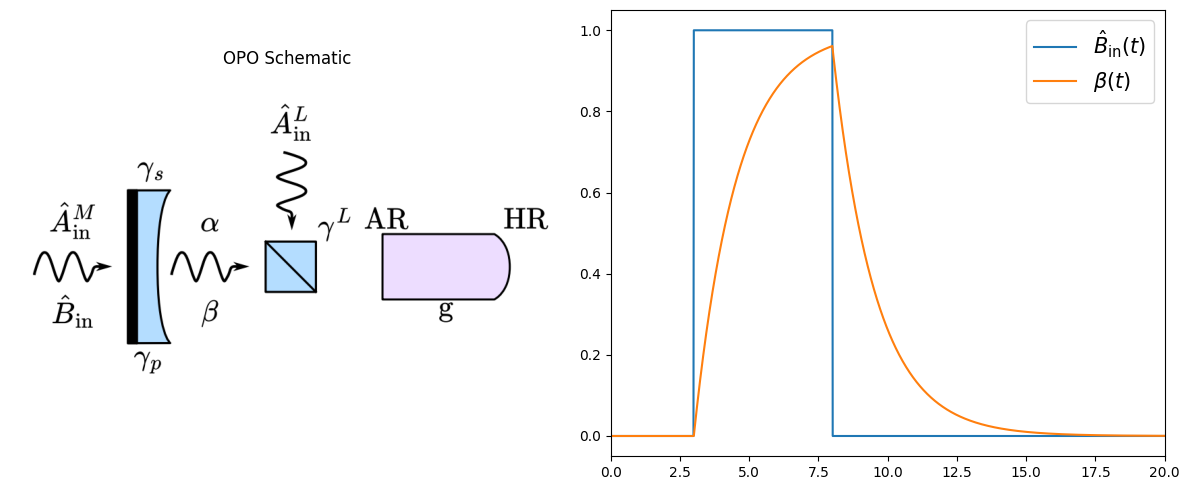

In [2]:
# Load image
img = mpimg.imread("schematics.png")
# Initialise Simulation
sim = TheoreticalPulsedSqueezing(pump_power = 1, simulation_time = 50, N_points = 4000, R_s = 94.5, R_p = 73.4, L_s = 0.2, L_p = 0.2, tau_cav = 222e-3)
sim.simulate_square_pulse(start_pulse=3, pulse_length=5)

# Create figure with 2 subplots (side by side)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Left: schematic
axs[0].imshow(img)
axs[0].axis("off")
axs[0].set_title("OPO Schematic")



axs[1].plot(sim.t, sim.input_pulse, label = r"$\hat{B}_{\text{in}}(t)$")
axs[1].plot(sim.t, sim.beta * sim.pump_power / sim.betamax, label=r"$\beta(t)$")
axs[1].legend(fontsize = 15)
axs[1].set_xlim((0,20))
plt.tight_layout()
plt.show()

Important quantities that will describe the squeezing modes are the **N** and **M** moment autocorrelation matrices.  
They can be derived using the **Langevin equations** for the signal field:

$$
\frac{d}{dt} 
\begin{pmatrix}
\hat{a} \\
\hat{a}^\dagger
\end{pmatrix}
=
\begin{pmatrix}
-\gamma_s & g\beta \\
g\beta & -\gamma_s
\end{pmatrix}
\begin{pmatrix}
\hat{a} \\
\hat{a}^\dagger
\end{pmatrix}
+ \sum_{i=M,L} \sqrt{2\gamma_s^i}
\begin{pmatrix}
\hat{A}^i_{\text{in}} \\
\hat{A}^{i\dagger}_{\text{in}}
\end{pmatrix}
$$

and the **input-output relations**:

$$
\begin{pmatrix}
\hat{A}^M_{\text{out}}(t) \\
\hat{A}^{M\dagger}_{\text{out}}(t)
\end{pmatrix}
=
\sqrt{2\gamma_s^M}
\begin{pmatrix}
\hat{a}(t) \\
\hat{a}^\dagger(t)
\end{pmatrix}
-
\begin{pmatrix}
\hat{A}^M_{\text{in}}(t) \\
\hat{A}^{M\dagger}_{\text{in}}(t)
\end{pmatrix}
$$

---

From these relations, the autocorrelation matrices can be computed as:

$$
N(t_1, t_2) = \langle \hat{A}^{M\dagger}_{\text{out}}(t_1)\hat{A}^M_{\text{out}}(t_2) \rangle 
= 2\gamma_s^M \left( H_2(t_1,0) H_2(t_2,0) 
+ 2\gamma_s \int_0^{\min\{t_1, t_2\}} du \, H_2(t_1,u) H_2(t_2,u) \right)
$$

$$
M(t_1, t_2) = \langle \hat{A}^M_{\text{out}}(t_1)\hat{A}^M_{\text{out}}(t_2) \rangle 
= 2\gamma_s^M \left( H_1(t_1,0) H_2(t_2,0) - H_2(t_2,t_1)U(t_2 - t_1) 
+ 2\gamma_s \int_0^{\min\{t_1,t_2\}} du \, H_1(t_1,u) H_2(t_2,u) \right)
$$

Where the functions \(H_1(t_1,t_2)\) and \(H_2(t_1,t_2)\) are given by:

$$
H_1(q,p) = e^{-\gamma_s (q-p)} \cdot \cosh \left( g \int_p^q \beta(s) \, ds \right)
$$

$$
H_2(q,p) = e^{-\gamma_s (q-p)} \cdot \sinh \left( g \int_p^q \beta(s) \, ds \right)
$$

It is just a matter of efficiently constructing these matrices and performing the integrals numerically to obtain the eigenmodes together with the squeezing.


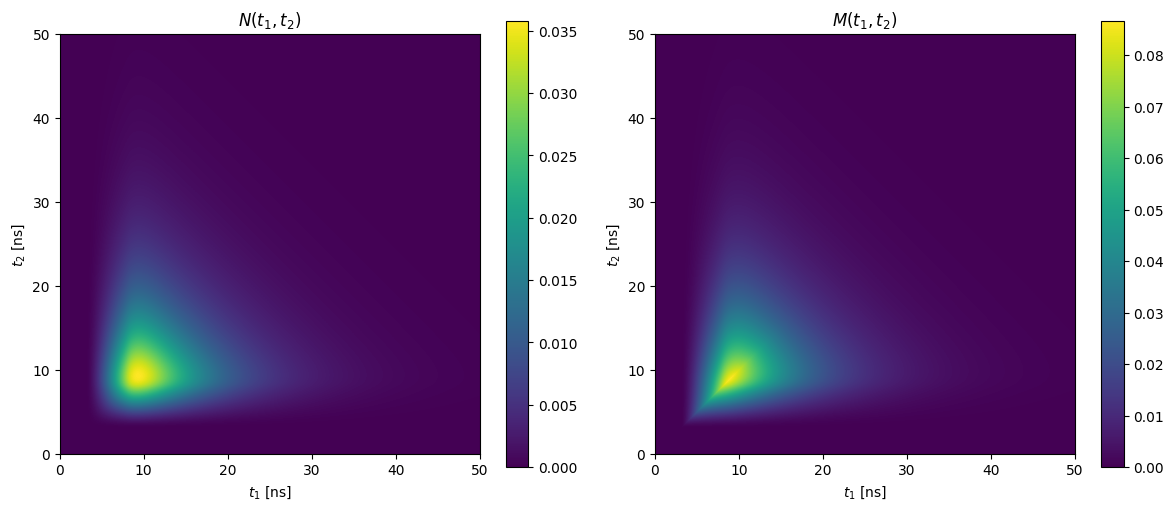

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# N matrix
im0 = axs[0].matshow(sim.N, origin='lower', extent=[sim.t[0], sim.t[-1], sim.t[0], sim.t[-1]])
axs[0].xaxis.set_ticks_position("bottom")
axs[0].set_xticks([0, 10, 20, 30, 40, 50])
axs[0].set_yticks([0, 10, 20, 30, 40, 50])
axs[0].set_xlabel(r"$t_1$ [ns]")
axs[0].set_ylabel(r"$t_2$ [ns]")
axs[0].set_title(r"$N(t_1, t_2)$")
fig.colorbar(im0, ax=axs[0])

# M matrix
im1 = axs[1].matshow(sim.M, origin='lower', extent=[sim.t[0], sim.t[-1], sim.t[0], sim.t[-1]])
axs[1].xaxis.set_ticks_position("bottom")
axs[1].set_xticks([0, 10, 20, 30, 40, 50])
axs[1].set_yticks([0, 10, 20, 30, 40, 50])
axs[1].set_xlabel(r"$t_1$ [ns]")
axs[1].set_ylabel(r"$t_2$ [ns]")
axs[1].set_title(r"$M(t_1, t_2)$")
fig.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()

Finally, one of the main quantities we care about is the **Schmidt number**, which measures the **effective number of modes** involved in the squeezing process.  

To compute it, we first diagonalize the **N moment matrix**. Its **eigenvalues** $n_k$ represent the occupation of each temporal mode, while the corresponding **eigenvectors** describe the temporal shape of those modes.  


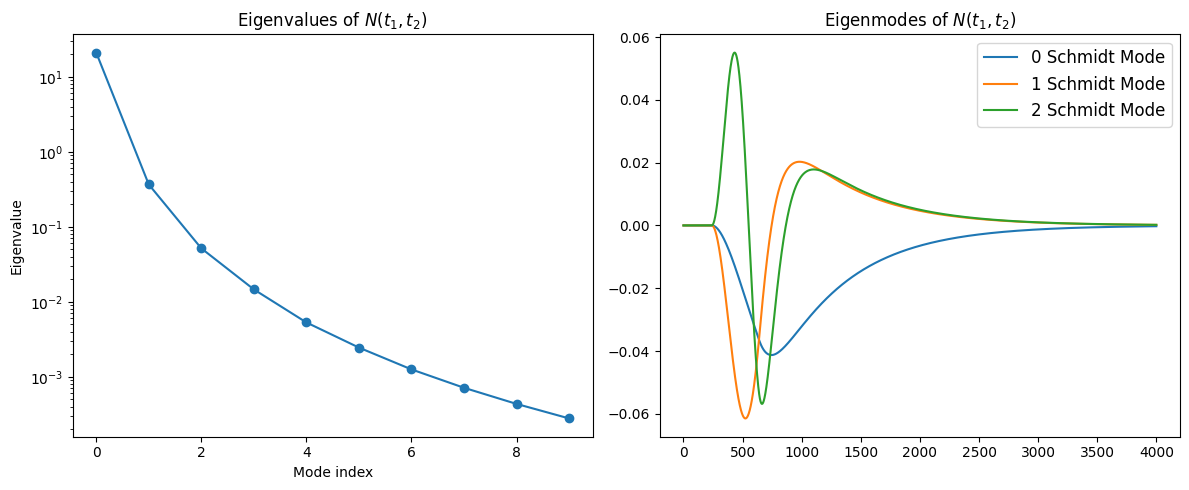

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))


# Middle: eigenvalues plot
plt.sca(axs[0])
plt.semilogy(sim.eigenvalues[::-1], 'o-')
plt.xlabel("Mode index")
plt.ylabel("Eigenvalue")
plt.title(r"Eigenvalues of $N(t_1,t_2)$")

# Right: eigenmodes plot
plt.sca(axs[1])
for i in range(3):
    plt.plot(sim.eigenvectors[:, -1 - i], label = f"{i} Schmidt Mode")
plt.title(r"Eigenmodes of $N(t_1,t_2)$")
plt.legend(fontsize = 12)

plt.tight_layout()
plt.show()

The **Schmidt number** is then defined as:

$$
K = \frac{\left( \sum_k n_k \right)^2}{\sum_k n_k^2}
$$

where $n_k$ are the eigenvalues of the \(N\) moment matrix.  

- If $K = 1$, the squeezing is contained in a single mode (pure single-mode squeezing).  
- If $K > 1$, the squeezing is distributed across multiple modes, with larger \(K\) indicating more multimode structure.  

In [5]:
print(f"Schmidt Mode: {sim.schmidt:.4f}")
print(f"Squeezing: {sim.squeezing:.4f}")
print(f"Anti-Squeezing: {sim.antisqueezing:.4f}")

Schmidt Mode: 1.0423
Squeezing: -4.0973
Anti-Squeezing: 4.2471


# Optimizing Cavity Parameters

When designing a pulsed squeezing cavity, there are two main goals:

- **Maximize squeezing:** Achieve the lowest possible quadrature variance.
- **Keep the Schmidt number close to 1:** Ensure the output remains essentially single-mode.

The challenge is to find the best cavity parameters that balance these objectives.  

I will now explore the class `TheoreticalPulsed1D` and analyze the resulting plots to extract insights about:

- How different cavity parameters affect the squeezing level.
- How the Schmidt number evolves with cavity tuning.

The ultimate goal is to identify a cavity configuration that maximizes squeezing while maintaining a nearly single-mode output.


Sweeping R_s:   0%|          | 0/101 [00:00<?, ?it/s]c:\Users\ocobo\OneDrive - Danmarks Tekniske Universitet\Skrivebord\PhD\qutip_pulsed\theoretical_pulsed.py:337: RuntimeWarning: invalid value encountered in log10
  self.squeezing_modes = 10*np.log10((self.first_term - self.second_term)*self.dt + 1)
Sweeping R_s: 100%|██████████| 101/101 [00:02<00:00, 33.74it/s]


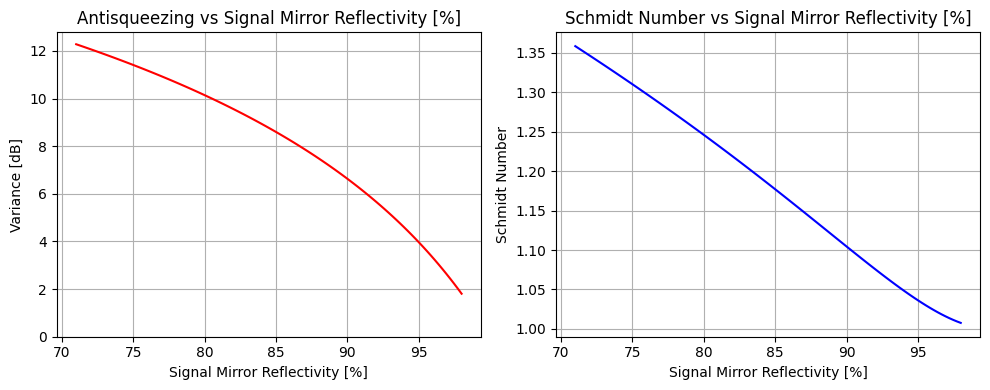

In [6]:
sim = TheoreticalPulsed1D(
    pump_power=1,
    simulation_time=100, 
    N_points=500,
    R_s = np.linspace(71,98,101),
    R_p = 73.4,
    L_s = 0.2,
    L_p = 0.2,
    tau_cav = 222e-3
)
sim.set_pulse_params(t_start = 3, t_rise = 0, t_plateau = 5, t_fall = 0)
sim.run()
sim.plot()

Sweeping R_p: 100%|██████████| 100/100 [00:03<00:00, 32.39it/s]


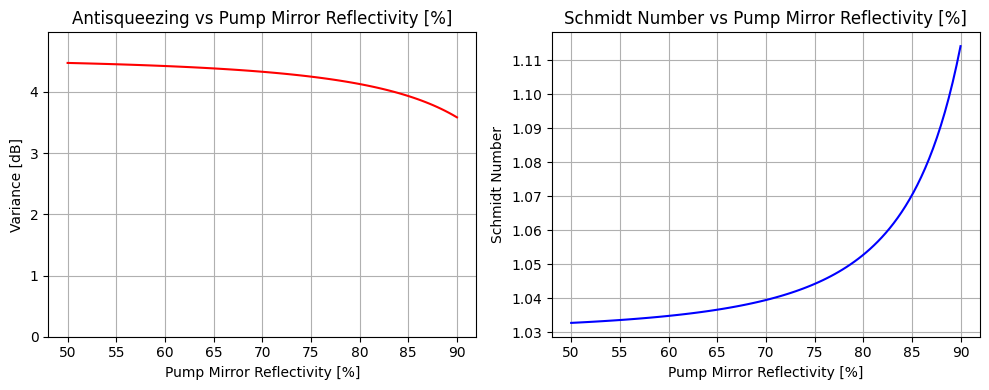

In [7]:
sim = TheoreticalPulsed1D(
    pump_power=1,
    simulation_time=100, 
    N_points=500,
    R_s = 94.5,
    R_p = np.linspace(50,90,100),
    L_s = 0.2,
    L_p = 0.2,
    tau_cav = 222e-3
)
sim.set_pulse_params(t_start = 3, t_rise = 0, t_plateau = 5, t_fall = 0)
sim.run()
sim.plot()

Sweeping tau_cav: 100%|██████████| 100/100 [00:03<00:00, 29.25it/s]


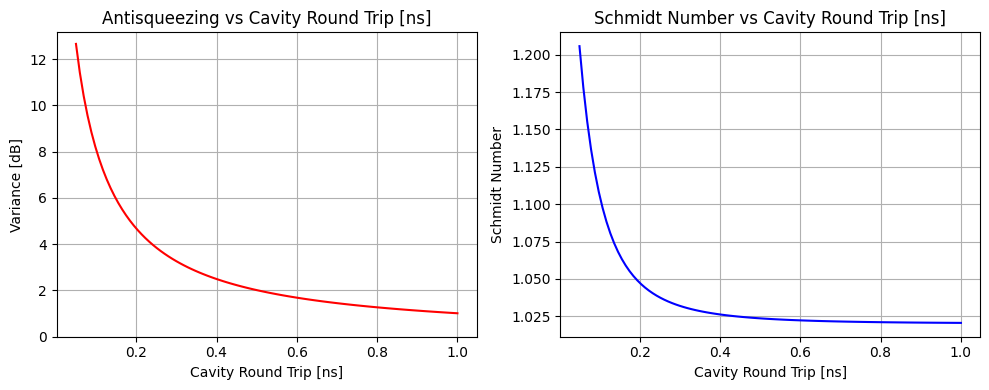

In [8]:
sim = TheoreticalPulsed1D(
    pump_power=1,
    simulation_time=100, 
    N_points=500,
    R_s = 94.5,
    R_p = 73.4,
    L_s = 0.2,
    L_p = 0.2,
    tau_cav = np.linspace(5e-2, 1, 100)
)
sim.set_pulse_params(t_start = 3, t_rise = 0, t_plateau = 5, t_fall = 0)
sim.run()
sim.plot()

Sweeping t_plateau: 100%|██████████| 100/100 [00:10<00:00,  9.35it/s]


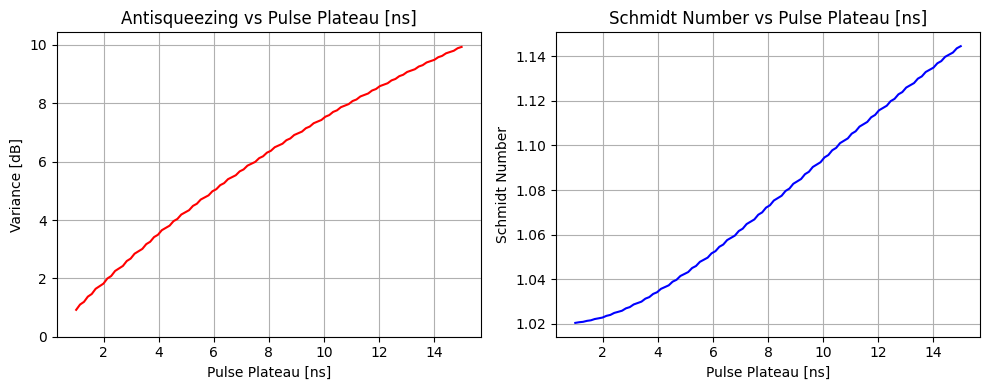

In [9]:
sim = TheoreticalPulsed1D(
    pump_power=1,
    simulation_time=100, 
    N_points=1000,
    R_s = 94.5,
    R_p = 73.4,
    L_s = 0.2,
    L_p = 0.2,
    tau_cav = 222e-3
)
sim.set_pulse_params(t_start = 3, t_rise = 0, t_plateau = np.linspace(1,15,100), t_fall = 0)
sim.run()
sim.plot()

# Interactive Plot for Pulsed Squeezing Simulation

This interactive visualization allows exploration of system parameters and their effects on schmidt number and squeezing.

## Layout

- **Top Left**: Input and intracavity field  
- **Top Right**: Eigenmodes of the system  
- **Bottom Left**: Eigenvalues spectrum  (title displays **Antisqueezing** and **Schmidt number** as key performance indicators.)
- **Bottom Right**: N-moment matrix  


## Usage

- Adjust the parameters with the interactive sliders to:
  - Modify the input pulse or cavity parameters
  - Observe changes in intracavity field evolution
  - Track eigenmodes and eigenvalues in real-time
  - Inspect the N-moment matrix structure
  - See how squeezing and Schmidt number vary

## Methods:
- `interact_custom_pulse(t, input_pulse)`  
  Allows defining a fully custom pulse by providing a time array `t` and a corresponding pulse amplitude array `input_pulse`.

- `interact_trapezoidal_pulse()`  
  Opens an interactive interface to create a trapezoidal pulse with adjustable rise, plateau, and fall times.

- `interact_gaussian_pulse()`  
  Opens an interactive interface to create a Gaussian pulse with adjustable center and width.

- `interact_square_pulse()`  
  Opens an interactive interface to create a perfect square pulse with adjustable start time and duration.

In [ ]:
vis = PulsedSqueezingVisualizer(TheoreticalPulsedSqueezing)
vis.interact_trapezoidal_pulse()

interactive(children=(FloatSlider(value=1.0, description='Pump Power', layout=Layout(width='450px'), max=5.0, …